In [1]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import mean_absolute_error
import shap

import cfbd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

## 1. Load the Data

In [2]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [3]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

In [4]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in YEARS:
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp = df_tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp = df_tmp.assign(
            home_division=df_tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=df_tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        df_tmp = df_tmp[id_cols + home_cols + away_cols]
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_games.head()

Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,start_date,home_id,home_team,home_conference,home_points,home_pregame_elo,away_id,away_team,away_conference,away_points,away_pregame_elo,home_division,away_division
0,332412309,2013,1,regular,True,False,3696.0,2013-08-29 22:00:00+00:00,2309,Kent State,Mid-American,17.0,1530.0,2335,Liberty,Big South,10.0,1467.0,fbs,fcs
1,332412579,2013,1,regular,True,False,3994.0,2013-08-29 22:00:00+00:00,2579,South Carolina,SEC,27.0,1759.0,153,North Carolina,ACC,10.0,1638.0,fbs,fbs
2,332410154,2013,1,regular,True,False,3630.0,2013-08-29 22:30:00+00:00,154,Wake Forest,ACC,31.0,NaN,2506,Presbyterian,Big South,7.0,NaN,fbs,fcs
3,332410084,2013,1,regular,True,False,3830.0,2013-08-29 23:00:00+00:00,84,Indiana,Big Ten,73.0,NaN,282,Indiana State,MVFC,35.0,NaN,fbs,fcs
4,332412413,2013,1,regular,True,False,3774.0,2013-08-29 23:00:00+00:00,2413,Morehead State,Pioneer,10.0,NaN,95,Pikeville,None,13.0,NaN,fcs,None


In [5]:
# Load weather data
all_dfs = []

weather_dir = join(DATA_DIR, 'weather')
if not os.path.exists(weather_dir):
    os.makedirs(weather_dir)

for year in YEARS:
    file_path = join(weather_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} weather data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_weather(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_weather = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_weather.head()

Reading ../data/weather/2013.parquet from cached data
Reading ../data/weather/2014.parquet from cached data
Reading ../data/weather/2015.parquet from cached data
Reading ../data/weather/2016.parquet from cached data
Reading ../data/weather/2017.parquet from cached data
Reading ../data/weather/2018.parquet from cached data
Reading ../data/weather/2019.parquet from cached data
Reading ../data/weather/2020.parquet from cached data
Reading ../data/weather/2021.parquet from cached data
Reading ../data/weather/2022.parquet from cached data
Reading ../data/weather/2023.parquet from cached data
Reading ../data/weather/2024.parquet from cached data


,id,season,week,season_type,start_time,game_indoors,home_team,home_conference,away_team,away_conference,venue_id,venue,temperature,dew_point,humidity,precipitation,snowfall,wind_direction,wind_speed,pressure,weather_condition_code,weather_condition
0,332412579,2013,1,regular,2013-08-29 22:00:00+00:00,False,South Carolina,SEC,North Carolina,ACC,3994,Williams-Brice Stadium,93.9,71.8,49.0,0.0,0,340.0,0.0,1011.7,NaN,None
1,332410254,2013,1,regular,2013-08-30 00:00:00+00:00,False,Utah,Pac-12,Utah State,Mountain West,587,Rice-Eccles Stadium,95.0,46.2,19.0,0.0,0,320.0,0.0,1012.6,NaN,None
2,332422247,2013,1,regular,2013-08-30 23:00:00+00:00,False,Georgia State,Sun Belt,Samford,Southern,3495,Georgia Dome,82.9,73.8,74.0,0.0,0,40.0,0.0,1012.9,NaN,None
3,332430059,2013,1,regular,2013-08-31 16:00:00+00:00,False,Georgia Tech,ACC,Elon,Southern,721,Bobby Dodd Stadium,84.0,72.0,67.0,0.0,0,250.0,0.0,1014.0,NaN,None
4,332430277,2013,1,regular,2013-08-31 16:00:00+00:00,False,West Virginia,Big 12,William & Mary,CAA,3842,Milan Puskar Stadium,79.0,67.1,67.0,0.0,0,230.0,0.0,1012.0,NaN,None


In [6]:
# Load venue data
venue_dir = join(DATA_DIR, 'venues')
if not os.path.exists(venue_dir):
    os.makedirs(venue_dir)

file_path = join(venue_dir, f'venues.parquet')
if os.path.exists(file_path):
    print(f'Reading {file_path} from cached data')
    df_venues = pd.read_parquet(file_path)
else:
    print(f'Fetching {year} venue data from CFBD API')
    with cfbd.ApiClient(configuration) as api_client:
        api_instance = cfbd.VenuesApi(api_client)
        data = api_instance.get_venues()
    df_venues = pd.DataFrame([val.to_dict() for val in data])
    df_venues.columns = convert_to_snake_case(df_venues.columns)
    df_venues.to_parquet(file_path)

df_venues.head()

Reading ../data/venues/venues.parquet from cached data


,id,name,city,state,zip,country_code,latitude,longitude,capacity,dome,timezone,elevation,construction_year,grass
0,5938,Al Whitehead Field at Greyhound Stadium,Portales,NM,88130,US,34.186192,-103.334397,4000.0,False,None,None,NaN,None
1,218,FIU Stadium,Miami,FL,33199,US,25.752501,-80.377891,20000.0,False,America/New_York,1.718581796,1995.0,False
2,4779,Thomas A. Robinson National Stadium,Nassau,,None,BS,25.055569,-77.358736,15000.0,False,None,3.182889223,1981.0,True
3,5220,Garrison Stadium,Murfreesboro,TN,None,US,36.434053,-77.098431,5000.0,False,None,18.69116974,2007.0,None
4,6043,Bethpage Federal Credit Union Stadium,Brookville,NY,11545,US,40.816284,-73.589546,6000.0,False,America/New_York,236,1966.0,False


In [7]:
# Load drives data
all_dfs = []

drives_dir = join(DATA_DIR, "drives")
if not os.path.exists(drives_dir):
    os.makedirs(drives_dir)

for year in YEARS:
    season_file_path = join(drives_dir, f"{year}.parquet")
    
    if os.path.exists(season_file_path):
        print(f"Reading {season_file_path} from cached data")
        df_season_drives = pd.read_parquet(season_file_path)
    else:
        print(f"Fetching {year} drives data from CFBD API")
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.DrivesApi(api_client)
            data = api_instance.get_drives(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)

        df_tmp["start_time_minutes"] = df_tmp["start_time"].apply(lambda x: x["minutes"])
        df_tmp["start_time_seconds"] = df_tmp["start_time"].apply(lambda x: x["seconds"])
        df_tmp["end_time_minutes"] = df_tmp["end_time"].apply(lambda x: x["minutes"])
        df_tmp["end_time_seconds"] = df_tmp["end_time"].apply(lambda x: x["seconds"])
        df_tmp.drop(columns=["start_time","end_time"], inplace=True)

        df_season_drives = df_tmp.copy()
                
        df_season_drives.to_parquet(season_file_path)
        print(f"Saved drives data for {year} to {season_file_path}")

    all_dfs.append(df_season_drives)
    
df_drives = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_drives.head()

Reading ../data/drives/2013.parquet from cached data
Reading ../data/drives/2014.parquet from cached data
Reading ../data/drives/2015.parquet from cached data
Reading ../data/drives/2016.parquet from cached data
Reading ../data/drives/2017.parquet from cached data
Reading ../data/drives/2018.parquet from cached data
Reading ../data/drives/2019.parquet from cached data
Reading ../data/drives/2020.parquet from cached data
Reading ../data/drives/2021.parquet from cached data
Reading ../data/drives/2022.parquet from cached data
Reading ../data/drives/2023.parquet from cached data
Reading ../data/drives/2024.parquet from cached data


,offense,offense_conference,defense,defense_conference,game_id,id,drive_number,scoring,start_period,start_yardline,start_yards_to_goal,end_period,end_yardline,end_yards_to_goal,plays,yards,drive_result,is_home_offense,start_offense_score,start_defense_score,end_offense_score,end_defense_score,start_time_minutes,start_time_seconds,end_time_minutes,end_time_seconds
0,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000601,1,False,1,25,75,1,36,64,6,11,PUNT,True,0,0,0,0,15,0,11,55
1,Southern Utah,Big Sky,South Alabama,Sun Belt,332410006,33241000602,2,True,1,77,77,1,16,16,12,61,FG GOOD,False,0,0,3,0,11,55,5,52
2,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000603,3,False,1,48,52,1,76,24,9,28,FG MISSED,True,0,3,0,3,5,52,2,21
3,Southern Utah,Big Sky,South Alabama,Sun Belt,332410006,33241000604,4,True,1,76,76,1,0,0,3,76,RUSHING TD,False,3,0,10,0,2,21,1,16
4,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000605,5,False,1,25,75,2,45,55,5,20,PUNT,True,0,10,0,10,1,16,14,53


In [8]:
punt_events = [c for c in df_drives.drive_result.unique() if 'PUNT' in c]
print(punt_events)
df_drives = df_drives[df_drives.drive_result.isin(punt_events)].reset_index(drop=True)
df_drives.shape

['PUNT', 'PUNT RETURN TD', 'PUNT TD', 'BLOCKED PUNT']


(112934, 26)

In [9]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
df_elos = pd.concat(elos, ignore_index=True).reset_index(drop=True)
df_elos = df_elos.drop_duplicates(subset=['season', 'week', 'team_id'], keep='first')
df_elos.head()

,season,week,season_type,team_id,team,division,elo
0,2013,1,regular,2,Auburn,fbs,2264.753528
1,2013,2,regular,2,Auburn,fbs,2254.767777
2,2013,3,regular,2,Auburn,fbs,2303.322874
3,2013,4,regular,2,Auburn,fbs,2344.906060
4,2013,6,regular,2,Auburn,fbs,2338.580248


## 2. Join and Filter the Data

In [10]:
game_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site',
    'venue_id', 'home_id', 'home_team', 'home_conference', 'home_division',
    'away_id', 'away_team','away_conference', 'away_division']
drive_cols = ['offense', 'defense',
       'game_id', 'id', 'drive_number', 'start_yards_to_goal',
       'end_yards_to_goal', 'drive_result',
       'end_offense_score', 'end_defense_score',
       'start_defense_score', 'start_offense_score',
       'start_period', 'start_time_minutes', 'start_time_seconds',
       'end_period', 'end_time_minutes', 'end_time_seconds']
weather_cols = ['id', 'game_indoors', 'temperature', 'dew_point', 'humidity',
       'precipitation', 'snowfall', 'wind_speed', 'pressure', 'weather_condition']
venue_cols = ['id', 'elevation', 'grass']
elo_cols = ['season', 'week', 'team_id', 'elo']

df = (
    df_games[game_cols].rename(columns={'id': 'game_id'})
    .merge(
        (
            df_drives
            [drive_cols]
            .rename(columns={'id': 'drive_id'})
        ),
        on=['game_id'],
        how='left',
    )
    .dropna(subset=['drive_id'])
    .merge(
        df_weather[weather_cols].rename(columns={'id': 'game_id'}),
        on=['game_id'],
        how='left',
    )
    .merge(
        df_venues[venue_cols].rename(columns={'id': 'venue_id'}),
        on=['venue_id'],
        how='left',
    )
    .merge(
        df_elos[elo_cols].rename(columns={'team_id': 'home_id', 'elo': 'home_pregame_elo'}),
        on=['season', 'week', 'home_id'],
        how='left'
    )
    .merge(
        df_elos[elo_cols].rename(columns={'team_id': 'away_id', 'elo': 'away_pregame_elo'}),
        on=['season', 'week', 'away_id'],
        how='left'
    )
)

df.head()

,game_id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,away_id,away_team,away_conference,away_division,offense,defense,drive_id,drive_number,start_yards_to_goal,end_yards_to_goal,drive_result,end_offense_score,end_defense_score,start_defense_score,start_offense_score,start_period,start_time_minutes,start_time_seconds,end_period,end_time_minutes,end_time_seconds,game_indoors,temperature,dew_point,humidity,precipitation,snowfall,wind_speed,pressure,weather_condition,elevation,grass,home_pregame_elo,away_pregame_elo
0,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230902,2.0,82.0,78.0,PUNT,0.0,7.0,7.0,0.0,1.0,6.0,51.0,1.0,4.0,50.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.3641663,False,1952.975932,1551.990878
1,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Kent State,Liberty,33241230903,3.0,58.0,55.0,PUNT,7.0,0.0,0.0,7.0,1.0,4.0,50.0,1.0,3.0,3.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.3641663,False,1952.975932,1551.990878
2,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230904,4.0,80.0,86.0,PUNT,0.0,7.0,7.0,0.0,1.0,3.0,3.0,1.0,2.0,6.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.3641663,False,1952.975932,1551.990878
3,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Kent State,Liberty,33241230905,5.0,55.0,44.0,PUNT,7.0,0.0,0.0,7.0,1.0,2.0,6.0,2.0,12.0,19.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.3641663,False,1952.975932,1551.990878
4,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230906,6.0,80.0,83.0,PUNT,0.0,7.0,7.0,0.0,2.0,12.0,19.0,2.0,12.0,19.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.3641663,False,1952.975932,1551.990878


In [11]:
df.drive_result.value_counts()

drive_result
PUNT              112012
PUNT RETURN TD       483
PUNT TD              429
BLOCKED PUNT          10
Name: count, dtype: int64

## 3. Feature Engineering

In [12]:
df = df.assign(
    end_drive_pct_game_played = (((df['end_period'] - 1) * 15 * 60) + ((15 * 60) - (df['end_time_minutes'] * 60 + df['end_time_seconds']))) / (4 * 15 * 60),
    start_drive_pct_game_played = (((df['start_period'] - 1) * 15 * 60) + ((15 * 60) - (df['start_time_minutes'] * 60 + df['start_time_seconds']))) / (4 * 15 * 60),
    game_seconds_remaining = ((4 * 15 * 60) - ((df['end_period'] - 1) * 15 * 60 + (15 * 60) - (df['end_time_minutes'] * 60 + df['end_time_seconds']))),
    score_diff = df['start_offense_score'] - df['start_defense_score'],
    is_home_team = np.select([df.neutral_site, df.offense == df.home_team], [0, 1], default=-1),
    offense_division = np.where(df['offense'] == df['home_team'], df['home_division'], df['away_division']),
    defense_division = np.where(df['offense'] == df['home_team'], df['away_division'], df['home_division']),
    grass = df.grass.fillna(False),
    game_indoors = df.game_indoors.fillna(False),
    temperature = np.where(df.game_indoors, 70, df.temperature.fillna(int(df.temperature.mean()))),
    wind_speed = np.where(df.game_indoors, 0, df.wind_speed.fillna(int(df.wind_speed.mean()))),
    elevation = df.elevation.fillna(int(df.elevation.astype(float).mean())),
    precipitation = np.where(df.game_indoors, 0, df.precipitation.fillna(int(df.precipitation.mean()))),
    punting_team_pregame_elo = np.where(df.home_team == df.offense, df.home_pregame_elo, df.away_pregame_elo),
    receiving_team_pregame_elo = np.where(df.home_team == df.offense, df.away_pregame_elo, df.home_pregame_elo),
    receiving_team_points_scored = df.end_defense_score - df.start_defense_score,
    punting_team_points_scored = df.end_offense_score - df.start_offense_score,
).assign(
    diff_time_ratio = lambda x: x['score_diff'] * np.exp(4 * (3600 - x['game_seconds_remaining']) / 3600),
)

df['elevation'] = df['elevation'].astype(float)    

df.head()

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_66342/711549339.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grass = df.grass.fillna(False),
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_66342/711549339.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  game_indoors = df.game_indoors.fillna(False),


,game_id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,away_id,away_team,away_conference,away_division,offense,defense,drive_id,drive_number,start_yards_to_goal,end_yards_to_goal,drive_result,end_offense_score,end_defense_score,start_defense_score,start_offense_score,start_period,start_time_minutes,start_time_seconds,end_period,end_time_minutes,end_time_seconds,game_indoors,temperature,dew_point,humidity,precipitation,snowfall,wind_speed,pressure,weather_condition,elevation,grass,home_pregame_elo,away_pregame_elo,end_drive_pct_game_played,start_drive_pct_game_played,game_seconds_remaining,score_diff,is_home_team,offense_division,defense_division,punting_team_pregame_elo,receiving_team_pregame_elo,receiving_team_points_scored,punting_team_points_scored,diff_time_ratio
0,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230902,2.0,82.0,78.0,PUNT,0.0,7.0,7.0,0.0,1.0,6.0,51.0,1.0,4.0,50.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1952.975932,1551.990878,0.169444,0.135833,2990.0,-7.0,-1,fcs,fbs,1551.990878,1952.975932,0.0,0.0,-13.786473
1,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Kent State,Liberty,33241230903,3.0,58.0,55.0,PUNT,7.0,0.0,0.0,7.0,1.0,4.0,50.0,1.0,3.0,3.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1952.975932,1551.990878,0.199167,0.169444,2883.0,7.0,1,fbs,fcs,1952.975932,1551.990878,0.0,0.0,15.526944
2,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230904,4.0,80.0,86.0,PUNT,0.0,7.0,7.0,0.0,1.0,3.0,3.0,1.0,2.0,6.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1952.975932,1551.990878,0.215000,0.199167,2826.0,-7.0,-1,fcs,fbs,1551.990878,1952.975932,0.0,0.0,-16.542125
3,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Kent State,Liberty,33241230905,5.0,55.0,44.0,PUNT,7.0,0.0,0.0,7.0,1.0,2.0,6.0,2.0,12.0,19.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1952.975932,1551.990878,0.294722,0.215000,2539.0,7.0,1,fbs,fcs,1952.975932,1551.990878,0.0,0.0,22.755322
4,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230906,6.0,80.0,83.0,PUNT,0.0,7.0,7.0,0.0,2.0,12.0,19.0,2.0,12.0,19.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1952.975932,1551.990878,0.294722,0.294722,2539.0,-7.0,-1,fcs,fbs,1551.990878,1952.975932,0.0,0.0,-22.755322


In [13]:
feasible_receiving_team_points_scored = [0, 6, 7, 8] # Disregarding the possibility of a safetys against punting team
feasible_punting_team_points_scored = [0, 2] # Disregarding the possibility of touchdowns scored by the punting team

df_punts = (
    df
    .rename(columns={
        'end_yards_to_goal':'punt_team_end_yards_to_goal',
        'end_drive_pct_game_played':'punt_team_end_pct_game_played',
    })
    .merge(
        (
            df[['game_id','drive_number','start_drive_pct_game_played','start_yards_to_goal']]
            .rename(columns={
                'start_yards_to_goal':'receiving_team_start_yards_to_goal',
                'start_drive_pct_game_played':'receiving_team_start_pct_game_played'
            })
            .assign(drive_number=lambda x: x['drive_number'] - 1)
        ),
        on=['game_id','drive_number'],
        how='left'
    )
    .dropna(subset=['receiving_team_start_yards_to_goal'])
    .query('receiving_team_points_scored in @feasible_receiving_team_points_scored and '
           'punting_team_points_scored in @feasible_punting_team_points_scored')
    .query('receiving_team_start_pct_game_played != 0.5')
    .drop(columns=['start_drive_pct_game_played'])
)

conditions = [
    df_punts.receiving_team_points_scored.isin([6,7,8]),
    df_punts.punting_team_points_scored == 2,
]
choices = [
    0,
    100
]
df_punts['receiving_team_start_yards_to_goal'] = np.select(conditions, choices, default=df_punts['receiving_team_start_yards_to_goal'])

In [14]:
df_punts.head()

,game_id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,away_id,away_team,away_conference,away_division,offense,defense,drive_id,drive_number,start_yards_to_goal,punt_team_end_yards_to_goal,drive_result,end_offense_score,end_defense_score,start_defense_score,start_offense_score,start_period,start_time_minutes,start_time_seconds,end_period,end_time_minutes,end_time_seconds,game_indoors,temperature,dew_point,humidity,precipitation,snowfall,wind_speed,pressure,weather_condition,elevation,grass,home_pregame_elo,away_pregame_elo,punt_team_end_pct_game_played,game_seconds_remaining,score_diff,is_home_team,offense_division,defense_division,punting_team_pregame_elo,receiving_team_pregame_elo,receiving_team_points_scored,punting_team_points_scored,diff_time_ratio,receiving_team_start_pct_game_played,receiving_team_start_yards_to_goal
0,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230902,2.0,82.0,78.0,PUNT,0.0,7.0,7.0,0.0,1.0,6.0,51.0,1.0,4.0,50.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1952.975932,1551.990878,0.169444,2990.0,-7.0,-1,fcs,fbs,1551.990878,1952.975932,0.0,0.0,-13.786473,0.169444,58.0
1,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Kent State,Liberty,33241230903,3.0,58.0,55.0,PUNT,7.0,0.0,0.0,7.0,1.0,4.0,50.0,1.0,3.0,3.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1952.975932,1551.990878,0.199167,2883.0,7.0,1,fbs,fcs,1952.975932,1551.990878,0.0,0.0,15.526944,0.199167,80.0
2,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230904,4.0,80.0,86.0,PUNT,0.0,7.0,7.0,0.0,1.0,3.0,3.0,1.0,2.0,6.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1952.975932,1551.990878,0.215000,2826.0,-7.0,-1,fcs,fbs,1551.990878,1952.975932,0.0,0.0,-16.542125,0.215000,55.0
3,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Kent State,Liberty,33241230905,5.0,55.0,44.0,PUNT,7.0,0.0,0.0,7.0,1.0,2.0,6.0,2.0,12.0,19.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1952.975932,1551.990878,0.294722,2539.0,7.0,1,fbs,fcs,1952.975932,1551.990878,0.0,0.0,22.755322,0.294722,80.0
6,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230911,11.0,75.0,59.0,PUNT,3.0,7.0,7.0,3.0,3.0,15.0,0.0,3.0,12.0,34.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1952.975932,1551.990878,0.540556,1654.0,-4.0,-1,fcs,fbs,1551.990878,1952.975932,0.0,0.0,-34.761713,0.540556,85.0


In [15]:
# Filter out overtime plays
df_punts = df_punts.query('0 < end_period <= 4')

# Game must be completed
df_punts = df_punts.query('completed == True')

df_punts = df_punts.query('0 <= receiving_team_start_pct_game_played <= 1')
df_punts = df_punts.query('0 <= punt_team_end_pct_game_played <= 1')

df_punts.reset_index(drop=True, inplace=True)

## 4. Feature Data Viz

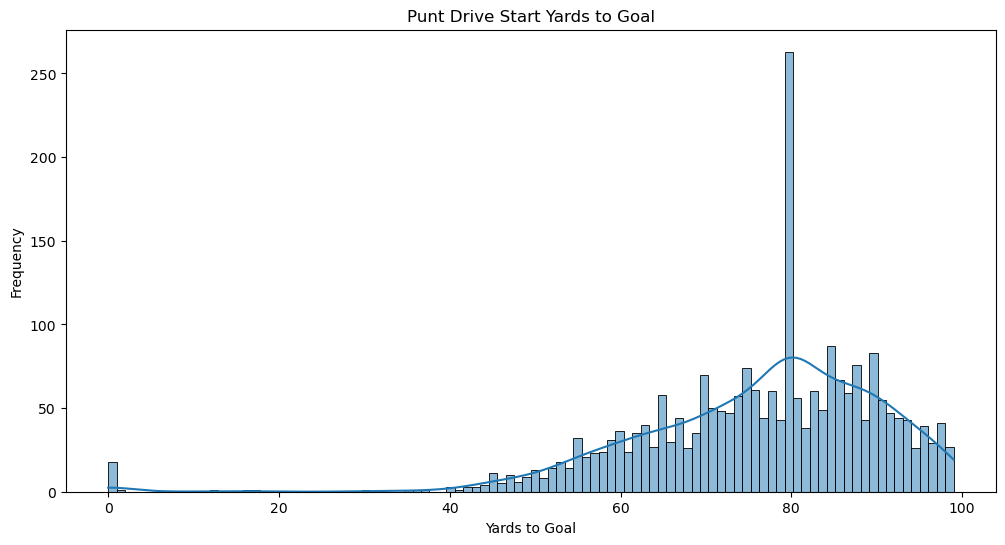

In [16]:
# plot a histogram of punt drive start yards to goal
plt.figure(figsize=(12,6))
sns.histplot(df_punts.query('season == 2024 and home_division == "fbs" and away_division == "fbs"').receiving_team_start_yards_to_goal, bins=100, kde=True)
plt.title("Punt Drive Start Yards to Goal")
plt.xlabel("Yards to Goal")
plt.ylabel("Frequency")
plt.show()

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_66342/913131268.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.cut(df_punts.punt_team_end_yards_to_goal, np.linspace(0, 100, 101)))


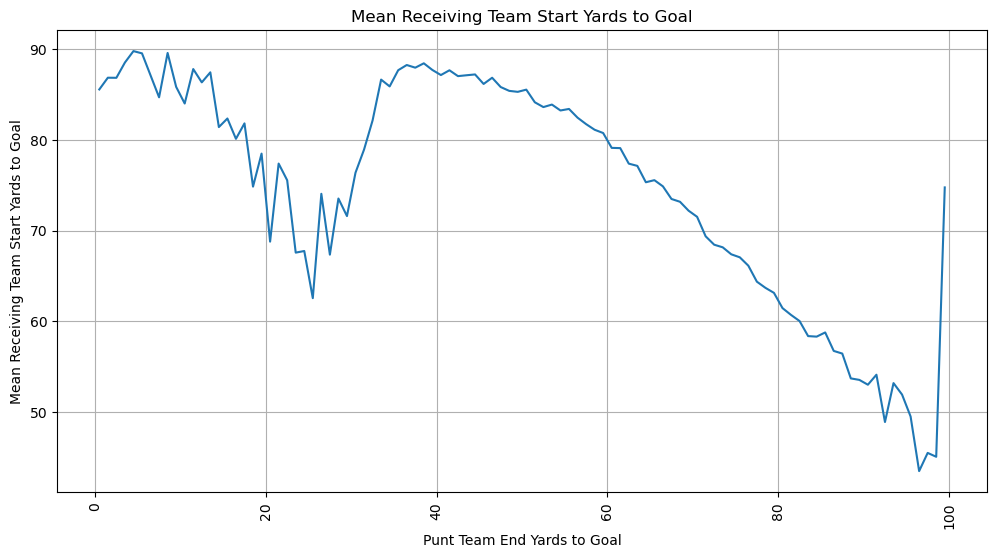

In [17]:
# Create the DataFrame with binned data
df_punt_start_yards_to_goal = (
    df_punts
    .groupby(pd.cut(df_punts.punt_team_end_yards_to_goal, np.linspace(0, 100, 101)))
    .agg(receiving_team_start_yards_to_goal_mean=('receiving_team_start_yards_to_goal', 'mean'))
    .reset_index()
)

# Convert the categorical bins to numeric midpoints
df_punt_start_yards_to_goal['punt_team_end_yards_to_goal'] = df_punt_start_yards_to_goal['punt_team_end_yards_to_goal'].apply(
    lambda x: x.mid if pd.notnull(x) else np.nan  # Use the midpoint of the bin
)

# Plot the mean receiving team start yards to goal
plt.figure(figsize=(12, 6))
sns.lineplot(
    x='punt_team_end_yards_to_goal', 
    y='receiving_team_start_yards_to_goal_mean', 
    data=df_punt_start_yards_to_goal
)
plt.title("Mean Receiving Team Start Yards to Goal")
plt.xlabel("Punt Team End Yards to Goal")
plt.ylabel("Mean Receiving Team Start Yards to Goal")
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [18]:
df_punts_inside_40 = df_punts.query('punt_team_end_yards_to_goal < 40').reset_index(drop=True)
df_punts = df_punts.query('punt_team_end_yards_to_goal >= 40').reset_index(drop=True)

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_66342/913131268.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.cut(df_punts.punt_team_end_yards_to_goal, np.linspace(0, 100, 101)))


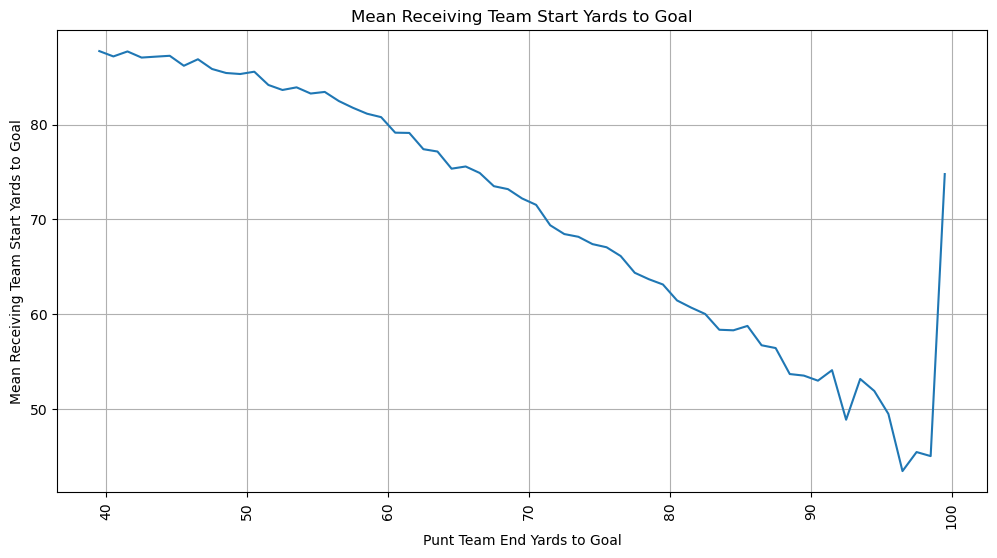

In [19]:
# Create the DataFrame with binned data
df_punt_start_yards_to_goal = (
    df_punts
    .groupby(pd.cut(df_punts.punt_team_end_yards_to_goal, np.linspace(0, 100, 101)))
    .agg(receiving_team_start_yards_to_goal_mean=('receiving_team_start_yards_to_goal', 'mean'))
    .reset_index()
)

# Convert the categorical bins to numeric midpoints
df_punt_start_yards_to_goal['punt_team_end_yards_to_goal'] = df_punt_start_yards_to_goal['punt_team_end_yards_to_goal'].apply(
    lambda x: x.mid if pd.notnull(x) else np.nan  # Use the midpoint of the bin
)

# Plot the mean receiving team start yards to goal
plt.figure(figsize=(12, 6))
sns.lineplot(
    x='punt_team_end_yards_to_goal', 
    y='receiving_team_start_yards_to_goal_mean', 
    data=df_punt_start_yards_to_goal
)
plt.title("Mean Receiving Team Start Yards to Goal")
plt.xlabel("Punt Team End Yards to Goal")
plt.ylabel("Mean Receiving Team Start Yards to Goal")
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [20]:
df_punts.columns

Index(['game_id', 'season', 'week', 'season_type', 'completed', 'neutral_site',
       'venue_id', 'home_id', 'home_team', 'home_conference', 'home_division',
       'away_id', 'away_team', 'away_conference', 'away_division', 'offense',
       'defense', 'drive_id', 'drive_number', 'start_yards_to_goal',
       'punt_team_end_yards_to_goal', 'drive_result', 'end_offense_score',
       'end_defense_score', 'start_defense_score', 'start_offense_score',
       'start_period', 'start_time_minutes', 'start_time_seconds',
       'end_period', 'end_time_minutes', 'end_time_seconds', 'game_indoors',
       'temperature', 'dew_point', 'humidity', 'precipitation', 'snowfall',
       'wind_speed', 'pressure', 'weather_condition', 'elevation', 'grass',
       'home_pregame_elo', 'away_pregame_elo', 'punt_team_end_pct_game_played',
       'game_seconds_remaining', 'score_diff', 'is_home_team',
       'offense_division', 'defense_division', 'punting_team_pregame_elo',
       'receiving_team_pregame_

In [23]:
# Only FBS offense
df = df.query('offense_division == "fbs"').reset_index(drop=True)

print(f'After filtering to FBS offense, {df.shape[0]} plays remain.')

After filtering to FBS offense, 88428 plays remain.


## 5. Modeling

In [24]:
feature_names = [  
    'punt_team_end_yards_to_goal', 
    # 'is_home_team', 
    # 'grass', 
    'elevation', 
    # 'wind_speed', 
    # 'precipitation', 
    'temperature', 
    # 'game_indoors',
    # 'punt_team_end_pct_game_played', 
    # 'score_diff',
    # 'diff_time_ratio',
    'punting_team_pregame_elo', 
    'receiving_team_pregame_elo',
]

data = (
    df_punts[['game_id'] + feature_names + ['receiving_team_start_yards_to_goal']]
    # .rename(columns={
    #     'punt_team_end_pct_game_played': 'pct_game_played',
    # })
)

# Split into 80-20 train val set by game_id
game_ids = df_punts.game_id.unique()
game_ids_train, game_ids_test = train_test_split(game_ids, test_size=0.2, random_state=42)

data_train = data[data.game_id.isin(game_ids_train)]
data_test = data[data.game_id.isin(game_ids_test)]

In [25]:
import statsmodels.api as sm

# Separate features and target
X_train = data_train[feature_names]
y_train = data_train['receiving_team_start_yards_to_goal']

X_test = data_test[feature_names]
y_test = data_test['receiving_team_start_yards_to_goal']

# Add intercept
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Fit OLS model
lr_model = sm.OLS(y_train, X_train_const).fit()

# Summary of the model
print(lr_model.summary())

# Predictions on train and test sets
y_pred_train = lr_model.predict(X_train_const)
y_pred_test = lr_model.predict(X_test_const)

# Example evaluation: R^2 on train/test
from sklearn.metrics import r2_score, mean_squared_error
print("Train R^2:", r2_score(y_train, y_pred_train))
print("Test R^2:", r2_score(y_test, y_pred_test))
print("Test RMSE:", mean_squared_error(y_test, y_pred_test, squared=False))
print("Test MAE:", mean_absolute_error(y_test, y_pred_test))

df_punts['pred_yards_to_goal_lr'] = lr_model.predict(sm.add_constant(df_punts[feature_names]))

                                    OLS Regression Results                                    
Dep. Variable:     receiving_team_start_yards_to_goal   R-squared:                       0.351
Model:                                            OLS   Adj. R-squared:                  0.351
Method:                                 Least Squares   F-statistic:                     3433.
Date:                                Sun, 28 Sep 2025   Prob (F-statistic):               0.00
Time:                                        19:14:51   Log-Likelihood:            -1.2480e+05
No. Observations:                               31735   AIC:                         2.496e+05
Df Residuals:                                   31729   BIC:                         2.497e+05
Df Model:                                           5                                         
Covariance Type:                            nonrobust                                         
                                  coef    std err 

/Users/lukeneuendorf/miniforge3/envs/4thdown/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test RMSE: 12.233710582243598
Test MAE: 8.064601543847317


In [26]:
from pygam import LinearGAM, s, f
import numpy as np

# Separate features and target
X_train = data_train[feature_names].values
y_train = data_train['receiving_team_start_yards_to_goal'].values

X_test = data_test[feature_names].values
y_test = data_test['receiving_team_start_yards_to_goal'].values

# Build a GAM
# s(i) = spline term (smooth nonlinear), f(i) = factor (categorical)
gam = LinearGAM(
    s(0, constraints="monotonic_dec") +  # punt_team_end_yards_to_goal (smooth)
    s(1, constraints="monotonic_inc") +  # elevation
    s(2, constraints="monotonic_inc") +  # temperature
    s(3, constraints="monotonic_inc") +  # punting_team_pregame_elo
    s(4, constraints="monotonic_dec")    # receiving_team_pregame_elo
).fit(X_train, y_train)

# Predictions
y_pred_train = gam.predict(X_train)
y_pred_test = gam.predict(X_test)

# Evaluation
from sklearn.metrics import r2_score, mean_squared_error
print("Train R^2:", r2_score(y_train, y_pred_train))
print("Test R^2:", r2_score(y_test, y_pred_test))
print("Test RMSE:", mean_squared_error(y_test, y_pred_test, squared=False))
print("Test MAE:", mean_absolute_error(y_test, y_pred_test))

# Plot partial dependence (shape functions)
import matplotlib.pyplot as plt
for i, feature in enumerate(feature_names):
    plt.figure()
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.title(f"Partial dependence of {feature}")
    plt.show()

df_punts['pred_yards_to_goal_gam'] = gam.predict(df_punts[feature_names].values)

KeyboardInterrupt: 

In [40]:
feature_names = [  
    'punt_team_end_yards_to_goal', 
    # 'is_home_team', 
    # 'grass', 
    'elevation', 
    'wind_speed', 
    'precipitation', 
    'temperature', 
    # 'game_indoors',
    # 'punt_team_end_pct_game_played', 
    # 'score_diff',
    # 'diff_time_ratio',
    'punting_team_pregame_elo', 
    'receiving_team_pregame_elo',
]

data = (
    df_punts[['game_id'] + feature_names + ['receiving_team_start_yards_to_goal']]
    # .rename(columns={
    #     'punt_team_end_pct_game_played': 'pct_game_played',
    # })
)

# Split into 80-20 train val set by game_id
game_ids = df_punts.game_id.unique()
game_ids_train, game_ids_test = train_test_split(game_ids, test_size=0.2, random_state=42)

data_train = data[data.game_id.isin(game_ids_train)]
data_test = data[data.game_id.isin(game_ids_test)]

data.isna().sum()

game_id                               0
punt_team_end_yards_to_goal           0
elevation                             0
wind_speed                            0
precipitation                         0
temperature                           0
punting_team_pregame_elo              0
receiving_team_pregame_elo            0
receiving_team_start_yards_to_goal    0
dtype: int64

In [41]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 2
np.random.seed(SEED)

feature_names = data_train.drop(columns=['game_id', 'receiving_team_start_yards_to_goal']).columns.tolist()
monotonic_constraints_map = {
    "punt_team_end_yards_to_goal": -1,
    "wind_speed": -1,
    "elevation": 1,
    "is_home_team": -1,
    "precipitation": -1,
    "punting_team_pregame_elo": 1,
    "receiving_team_pregame_elo": -1,
}
monotonic_constraints = tuple([monotonic_constraints_map.get(feature, 0) for feature in feature_names])

interaction_constraints = []

# Prepare data
train, valid = train_test_split(data_train, test_size=0.2, random_state=SEED)
train_x = train.drop(columns=['game_id', 'receiving_team_start_yards_to_goal'])
train_y = train['receiving_team_start_yards_to_goal']
valid_x = valid.drop(columns=['game_id', 'receiving_team_start_yards_to_goal'])
valid_y = valid['receiving_team_start_yards_to_goal']

dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

# Objective function
def objective(trial):
    param = {
        "nthread": -1,
        "objective": "reg:absoluteerror",
        "monotone_constraints": monotonic_constraints,
        "interaction_constraints": interaction_constraints,
        "eval_metric": "mae",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False
    )
    preds = bst.predict(dvalid)
    return mean_absolute_error(valid_y, preds)

# Run optimization
study = optuna.create_study(
    study_name="punt_yards_to_goal",
    direction="minimize", 
    load_if_exists=True
)
study.optimize(objective, n_trials=50)

# Train final model
best_params = {
    **study.best_trial.params,
    'interaction_constraints': interaction_constraints,
    'nthread': -1,
    'objective': 'reg:absoluteerror',
    'booster': 'gbtree',
    'monotone_constraints': monotonic_constraints,
    'eval_metric': 'mae',
    'seed': SEED,
}

final_model = xgb.train(
    best_params, 
    dtrain,
    num_boost_round=500,
    evals=[(dvalid, "eval")],
    early_stopping_rounds=10,
    verbose_eval=False
)

# Train MAE
train_preds = final_model.predict(dtrain)
train_mse = mean_absolute_error(train_y, train_preds)
print(f"Train MAE: {train_mse:.4f}")

# Validation MAE
valid_preds = final_model.predict(dvalid)
valid_mse = mean_absolute_error(valid_y, valid_preds)
print(f"Validation MAE: {valid_mse:.4f}")

# Test MAE
test_x = data_test.drop(columns=['game_id', 'receiving_team_start_yards_to_goal'])
test_y = data_test['receiving_team_start_yards_to_goal']
dtest = xgb.DMatrix(test_x, label=test_y)
test_preds = final_model.predict(dtest)
test_mse = mean_absolute_error(test_y, test_preds)
print(f"Test MAE: {test_mse:.4f}")

Train MAE: 7.9406
Validation MAE: 7.7341
Test MAE: 7.8969


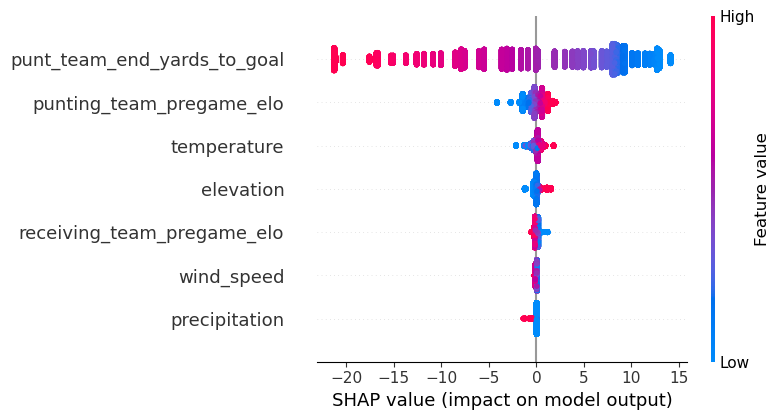

In [42]:
import shap
background = train[feature_names]
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(background)
shap.summary_plot(shap_values, 
                 background, 
                 plot_type="dot",  # "dot" (default), "bar", or "violin"
                 max_display=15,
                 show=True)

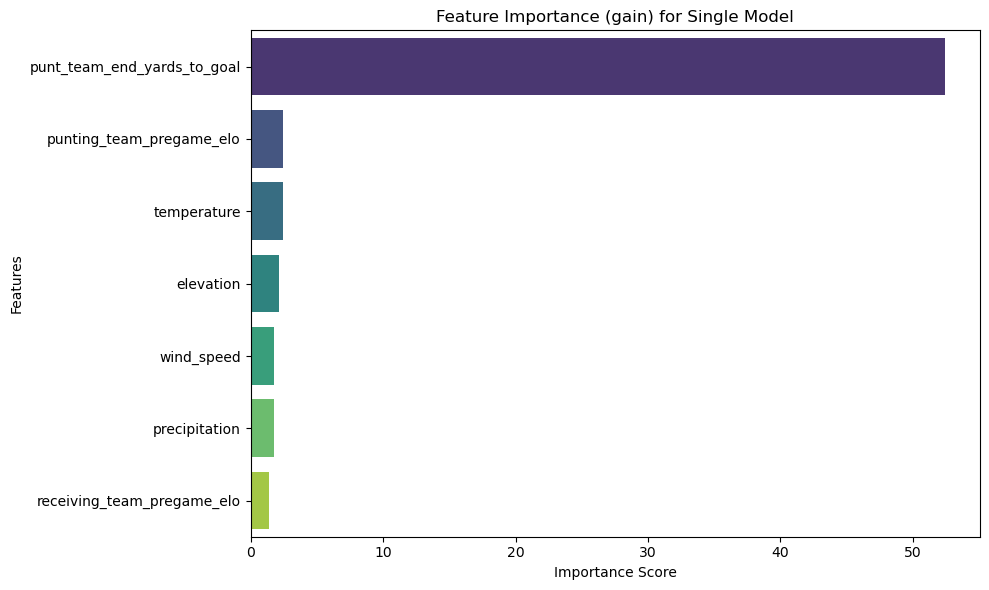

In [43]:
importance_type = "gain"  # Options: "gain", "weight", "cover"

# Get feature importance for a single model
importance = final_model.get_score(importance_type=importance_type)

# Convert to DataFrame and sort
importance_df = pd.DataFrame({
    "Feature": list(importance.keys()),
    "Importance": list(importance.values())
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", 
    y="Feature", 
    data=importance_df, 
    palette="viridis", 
    hue="Feature", 
    dodge=False
)
plt.title(f"Feature Importance ({importance_type}) for Single Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

In [44]:
# predict pred_yards_to_goal for all plays
df_punts['pred_yards_to_goal'] = final_model.predict(
    xgb.DMatrix(df_punts[feature_names])
)

In [31]:
df_punts.columns

Index(['game_id', 'season', 'week', 'season_type', 'completed', 'neutral_site',
       'venue_id', 'home_id', 'home_team', 'home_conference', 'home_division',
       'away_id', 'away_team', 'away_conference', 'away_division', 'offense',
       'defense', 'drive_id', 'drive_number', 'start_yards_to_goal',
       'punt_team_end_yards_to_goal', 'drive_result', 'end_offense_score',
       'end_defense_score', 'start_defense_score', 'start_offense_score',
       'start_period', 'start_time_minutes', 'start_time_seconds',
       'end_period', 'end_time_minutes', 'end_time_seconds', 'game_indoors',
       'temperature', 'dew_point', 'humidity', 'precipitation', 'snowfall',
       'wind_speed', 'pressure', 'weather_condition', 'elevation', 'grass',
       'home_pregame_elo', 'away_pregame_elo', 'punt_team_end_pct_game_played',
       'game_seconds_remaining', 'score_diff', 'is_home_team',
       'offense_division', 'defense_division', 'punting_team_pregame_elo',
       'receiving_team_pregame_

MAE (XGB + LR): 7.962195535314056
MAE (XGB): 7.898818015618166
MAE (LR): 8.113403022724546


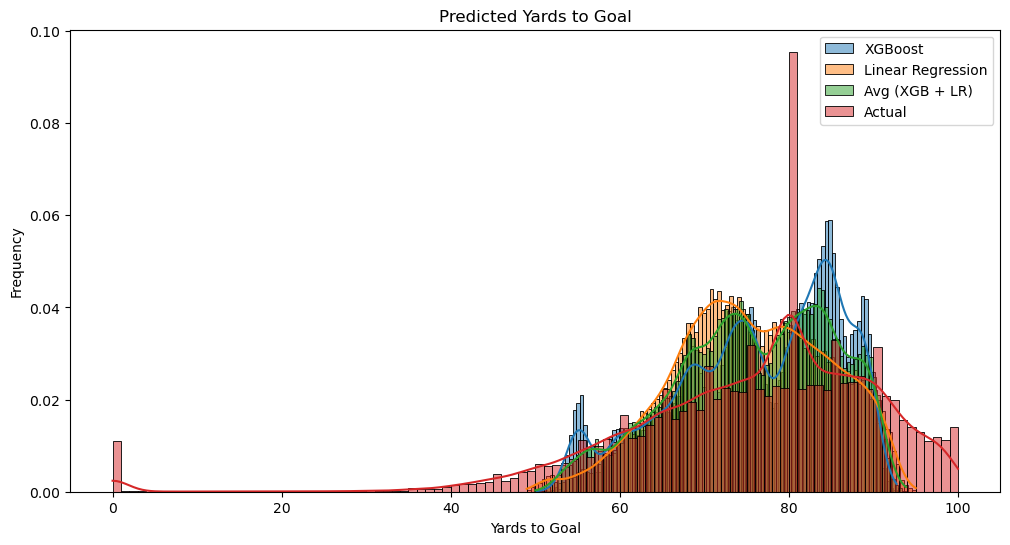

In [45]:
plt.figure(figsize=(12,6))
sns.histplot(df_punts.pred_yards_to_goal, bins=100, kde=True, stat='density', label='XGBoost')
sns.histplot(df_punts.pred_yards_to_goal_lr, bins=100, kde=True, stat='density', label='Linear Regression')
# sns.histplot(df_punts.pred_yards_to_goal_gam, bins=100, kde=True, stat='density', label='GAM')
# average linear regression and xgboost
df_punts['pred_yards_to_goal_avg'] = (df_punts['pred_yards_to_goal'] + df_punts['pred_yards_to_goal_lr']) / 2  
print("MAE (XGB + LR):", mean_absolute_error(df_punts.receiving_team_start_yards_to_goal, df_punts.pred_yards_to_goal_avg))
print("MAE (XGB):", mean_absolute_error(df_punts.receiving_team_start_yards_to_goal, df_punts.pred_yards_to_goal))
print("MAE (LR):", mean_absolute_error(df_punts.receiving_team_start_yards_to_goal, df_punts.pred_yards_to_goal_lr))
sns.histplot(df_punts.pred_yards_to_goal_avg, bins=100, kde=True, stat='density', label='Avg (XGB + LR)')
sns.histplot(df_punts.receiving_team_start_yards_to_goal, bins=100, kde=True, stat='density', label='Actual')
plt.title("Predicted Yards to Goal")
plt.xlabel("Yards to Goal")
plt.ylabel("Frequency")
plt.legend()
plt.show()


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_66342/2291716976.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('yards_bin')
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_66342/2291716976.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_punt_start_yards_to_goal['pred_yards_to_goal_mean'] = df_punt_start_yards_to_goal['pred_yards_to_goal_mean'].fillna(method='ffill')
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_66342/2291716976.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_punt_start_yards_to_goal['receiving_team_start_yards_to_goal_mean'] = df_punt_start_

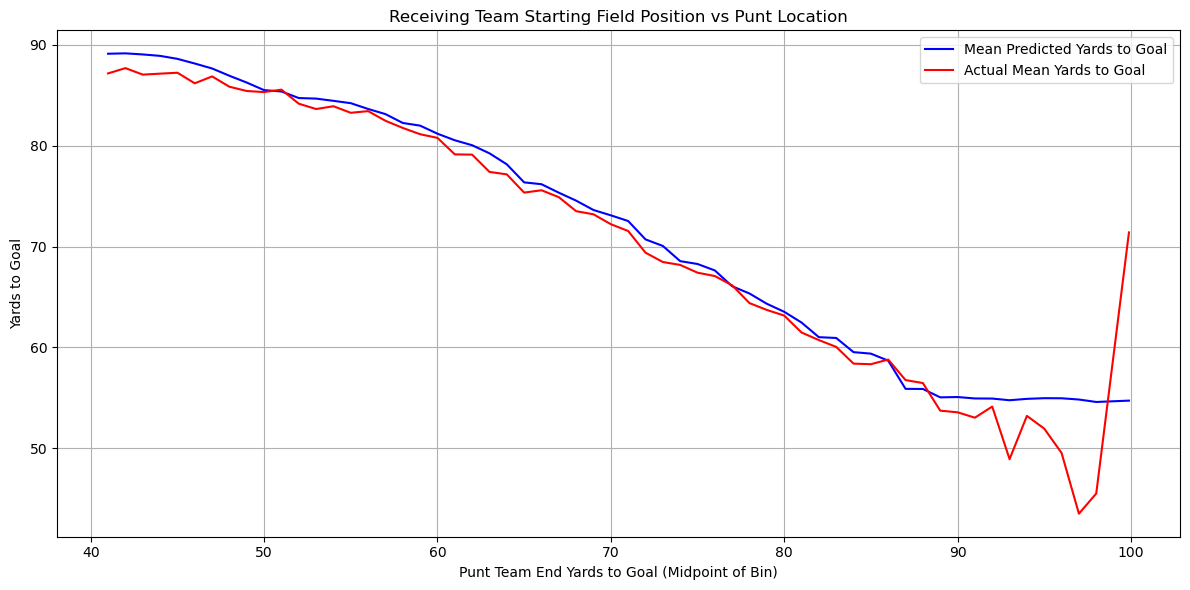

In [46]:
# Create the DataFrame with binned data
df_punt_start_yards_to_goal = (
    df_punts
    .assign(
        yards_bin=pd.cut(df_punts.punt_team_end_yards_to_goal, np.linspace(40, 100, 60))
    )
    .groupby('yards_bin')
    .agg(
        pred_yards_to_goal_mean=('pred_yards_to_goal', 'mean'),
        receiving_team_start_yards_to_goal_mean=('receiving_team_start_yards_to_goal', 'mean'),
        bin_midpoint=('punt_team_end_yards_to_goal', lambda x: x.mean())  # Calculate midpoint for plotting
    )
    .reset_index()
)

# Fill NA with previous value
df_punt_start_yards_to_goal['pred_yards_to_goal_mean'] = df_punt_start_yards_to_goal['pred_yards_to_goal_mean'].fillna(method='ffill')
df_punt_start_yards_to_goal['receiving_team_start_yards_to_goal_mean'] = df_punt_start_yards_to_goal['receiving_team_start_yards_to_goal_mean'].fillna(method='ffill')

# Plot with uncertainty shading
plt.figure(figsize=(12, 6))

# Prediction line
sns.lineplot(
    x='bin_midpoint',  # Use numeric midpoint instead of interval
    y='pred_yards_to_goal_mean', 
    data=df_punt_start_yards_to_goal,
    color='blue',
    label='Mean Predicted Yards to Goal'
)

# Actual mean
sns.lineplot(
    x='bin_midpoint',  # Use numeric midpoint instead of interval
    y='receiving_team_start_yards_to_goal_mean', 
    data=df_punt_start_yards_to_goal,
    color='red',
    label='Actual Mean Yards to Goal'
)

plt.title("Receiving Team Starting Field Position vs Punt Location")
plt.xlabel("Punt Team End Yards to Goal (Midpoint of Bin)")
plt.ylabel("Yards to Goal")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [47]:
data.drop_duplicates(['game_id']).head(10)

,game_id,punt_team_end_yards_to_goal,elevation,wind_speed,precipitation,temperature,punting_team_pregame_elo,receiving_team_pregame_elo,receiving_team_start_yards_to_goal
0,332412309,78.0,321.364166,3.4,0.0,82.0,1551.990878,1952.975932,58.0
5,332412579,52.0,60.545486,0.0,0.0,93.9,2473.889755,3033.615891,94.0
7,332410154,85.0,283.548584,13.9,0.0,84.0,803.247590,1960.287937,45.0
13,332410084,69.0,231.650085,5.8,0.0,88.0,1481.965547,1735.469227,59.0
15,332412050,82.0,285.481781,5.8,0.0,82.9,1725.851812,1898.375626,64.0
20,332410135,66.0,254.390228,10.3,0.0,90.0,1168.780785,2011.439292,97.0
23,332412116,76.0,20.941137,8.1,0.0,86.0,806.251300,2169.839280,74.0
28,332410189,72.0,205.905746,5.8,0.0,82.9,2251.436655,1764.705637,62.0
33,332412393,84.0,191.727982,10.3,0.0,92.8,712.764519,1520.680391,0.0
38,332410006,55.0,9.828814,7.0,0.0,87.1,1046.163955,1477.646472,89.0


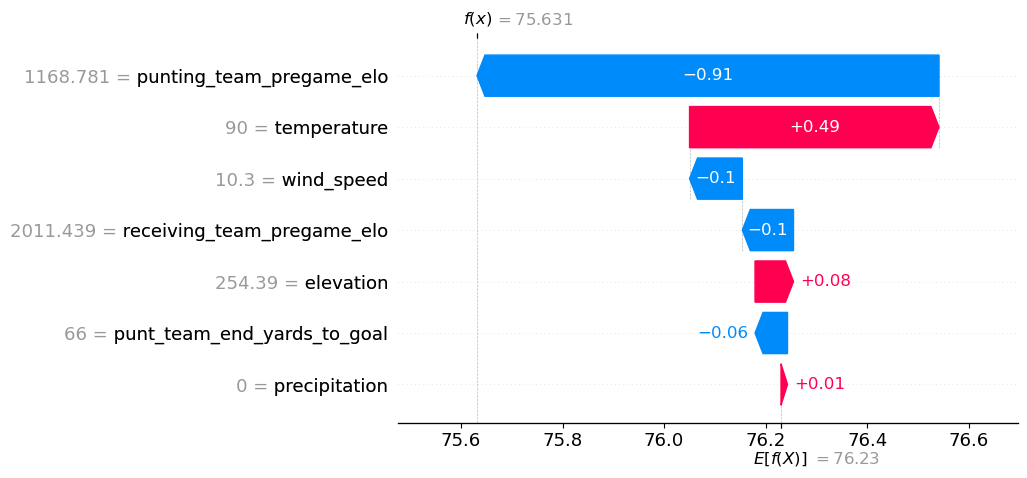

In [48]:
gid = 332410135


game_data = data[data.game_id == gid].drop(columns=['game_id','receiving_team_start_yards_to_goal']).head(1)

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(game_data)
shap_values_explained = shap.Explanation(values=shap_values, 
                                         base_values=explainer.expected_value, 
                                         data=game_data, 
                                         feature_names=game_data.columns)

shap.plots.waterfall(shap_values_explained[0])
plt.show()

### Make assumptions for punts inside the 40, that median yards to goal is 89 yards

In [49]:
df_punts_inside_40['pred_yards_to_goal'] = 89

df_punts_final = pd.concat([df_punts, df_punts_inside_40], ignore_index=True)

In [50]:
model_dir = join('..', '..', 'inference',  'models', 'punt_yards_to_goal')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, f"xgb_classifier.json")
final_model.save_model(model_path)

print(f"Saved model to the '{model_dir}' folder.")

Saved model to the '../../inference/models/punt_yards_to_goal' folder.


In [51]:
model_dir = join('..', '..', 'inference', 'models', 'punt_yards_to_goal')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
lr_model.save(join(model_dir, 'linear_regression_model.pkl'))